In [3]:
! pip install black[jupyter]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.2 MB/s eta 0:00:00


In [ ]:
! black ./

In [1]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
discount = pd.read_csv("discountuplift.csv", sep="\t")


# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)

    N_c = sum(ranked["target_class"] <= 1)
    N_t = sum(ranked["target_class"] >= 2)

    # посчитаем в отсортированном датафрейме основные показатели,
    # которые используются при расчёте Qini Score
    ranked["n_c1"] = 0
    ranked["n_t1"] = 0
    ranked.loc[ranked.target_class == 1, "n_c1"] = 1
    ranked.loc[ranked.target_class == 3, "n_t1"] = 1
    ranked["n_c1/nc"] = ranked.n_c1.cumsum() / N_c
    ranked["n_t1/nt"] = ranked.n_t1.cumsum() / N_t

    # посчитаем Qini-кривую и случайную прямую под ней
    ranked["uplift"] = round(ranked["n_t1/nt"] - ranked["n_c1/nc"], 5)
    # добавим случайную кривую
    ranked["random_uplift"] = round(
        ranked["uplift_score"].rank(pct=True, ascending=False)
        * ranked["uplift"].iloc[-1],
        5,
    )

    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked["n"], ranked["uplift"], color="r")
    plt.plot(ranked["n"], ranked["random_uplift"], color="b")
    plt.show()

    return (ranked["uplift"] - ranked["random_uplift"]).sum()


discount["old_target"] = (discount["target_class"] % 2 == 0).apply(int)

feature_cols = [
    "recency",
    "history",
    "used_discount",
    "used_bogo",
    "is_referral",
    "zip_code_Rural",
    "zip_code_Surburban",
    "zip_code_Urban",
    "channel_Multichannel",
    "channel_Phone",
    "channel_Web",
]
target_col = "old_target"
treatment_col = "treatment"

# разобъём нашу выборку на тестовую и валидационную

df_train, df_test = train_test_split(
    discount,
    stratify=discount[[treatment_col, target_col]],
    random_state=1,
    test_size=0.25,
)
df_train.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target
309,10,95.49,0,1,1,1,1,0,0,0,0,1,0.385971,0.033124,0.501814,0.079090,0.114224,2,1
5927,6,293.78,1,1,1,0,0,1,0,0,0,1,0.522508,0.060261,0.311440,0.105791,0.300301,1,0
8778,6,29.99,0,1,1,0,0,1,0,0,0,1,0.453994,0.041645,0.437831,0.066529,0.095770,0,1
11331,5,467.42,1,1,0,0,0,0,1,0,1,0,0.405045,0.134821,0.225336,0.234798,0.521099,0,1
4924,2,326.64,1,0,0,1,0,0,1,0,1,0,0.514283,0.047125,0.370299,0.068294,0.143541,3,0


In [3]:
from causalml.inference.meta import (
    BaseXClassifier,
)  # импортируйте необходимый класс из causalml (базовый классификатор)
from sklearn.linear_model import LogisticRegression, LinearRegression

# создадим базовый X-learner
x_learner = BaseXClassifier(
    outcome_learner=LogisticRegression(random_state=13, verbose=0),
    effect_learner=LinearRegression(),
)  # создайте классификатор с логистической регрессией,
# указав outcome_learner=LogisticRegression(random_state=13)
# и линейной регрессией для uplift-классификатора
# указав effect_learner=LinearRegression()

# для обучения нужны датафрейм с факторами и колонка с фактом воздействия
x_learner.fit(
    X=df_train[feature_cols], treatment=df_train[treatment_col], y=df_train[target_col]
)

uplift_vals = x_learner.predict(np.array(df_test[feature_cols].values.copy()))

# оцените Qini Score для обученного классификатора на тестовой выборке

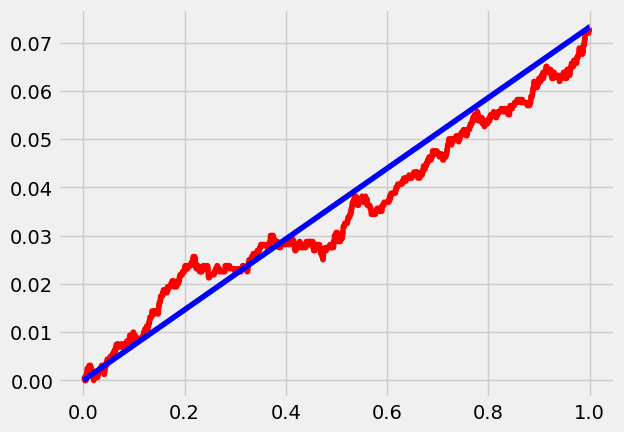

-5.694039999999998

In [4]:
# оцените качество
df_test["uplift_score"] = uplift_vals

# посчитаем Qini Score по нашему датасету
qini_df(df_test)